# Projekt 2
#### Bartosz Eljasiak, Mateusz Grzyb, Mariusz Słapek

In [106]:
import numpy as np
import pandas as pd

from scipy.stats import uniform, expon, randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

from joblib import dump, load

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

## Przygotowanie danych

Dane obrabiamy w sposób identyczny, jak na poprzednim etapie projektu, gdzie też znajdują się szczegółowe opisy poszczególnych etapów.

### Wczytanie danych

In [83]:
raw_data = pd.read_csv('../data/online_shoppers_intention.csv')

### Skalowanie zmiennych numerycznych

In [84]:
data = raw_data.copy()
variables = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
scaler = MinMaxScaler()

data[variables] = scaler.fit_transform(data[variables])

### Kodowanie zmiennej 'Month'

In [85]:
month_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data['Month'] = data['Month'].replace(month_to_int)

data['Month_x']=data['Month'].transform(lambda x: np.sin((np.pi/6)*x))
data['Month_y']=data['Month'].transform(lambda x: np.cos((np.pi/6)*x))

data = data.drop('Month', axis=1)

### Kodowanie zmiennych kategorycznych

In [86]:
encoder = OneHotEncoder(sparse=False)
temp = pd.DataFrame(encoder.fit_transform(data[['VisitorType']]))
temp.columns = encoder.get_feature_names(['VisitorType'])
data = pd.concat([data, temp], axis=1)
data = data.drop('VisitorType', axis=1)

variables = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

for variable in variables:
    values_to_leave = data[variable].value_counts()[:4].index.tolist()
    data[variable] = data[variable].transform(lambda x: x if (x in values_to_leave) else 'other').astype(str)
    
    encoder = OneHotEncoder(sparse=False)
    temp = pd.DataFrame(encoder.fit_transform(data[[variable]]))
    temp.columns = encoder.get_feature_names([variable])
    data = pd.concat([data, temp], axis=1)
    data = data.drop(variable, axis=1)

### Kodowanie zmiennych typu Bool

In [87]:
variables=  ['Weekend', 'Revenue']

for variable in variables:
    data[variable] = data[variable].transform(lambda x: 1 if x else 0)

### Efekt końcowy

In [88]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_x,Month_y,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other
0,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.002837,0.001000,0.000000,0.500000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.002837,0.000042,0.250000,0.700000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.000000,0.0,0.0,0.014184,0.009809,0.100000,0.250000,0.000000,0.0,1,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,1,0,-2.449294e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,0,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Motywacja i metodyka

Na ostatnim etapie projektu chcielibyśmy rozwinąć pomysł zapoczątkowany dwa tygodnie temu.

Przypomnijmy najpierw rozważany uprzednio podział na grupy, dokonany z wykorzystaniem wszystkich atrybutow, poza 'Revenue_ratio'.

Funkcja _predict dokonuje klasteryzacji danych wybraną metodą i zwraca podział w postaci wektora.

In [89]:
def _predict(data, model):
    model.fit(data)
    if hasattr(model, 'labels_'):
        prediction = model.labels_.astype(np.int)
    else:
        prediction = model.predict(X)
    return prediction

Funkcja grouped_revenue dokonuje klasteryzacji danych (bez zmiennej 'Revenue') wybraną metodą i zwraca wykresy liczności grup oraz odsetków sesji zakończonych przychodem dla każdej grupy.

In [90]:
def grouped_revenue(data, model):
    prediction = _predict(data.drop('Revenue', axis=1), model)
    plotdata = pd.DataFrame({'Group': prediction, 'Revenue': data['Revenue']})
    plotdata = pd.crosstab(plotdata['Group'], plotdata['Revenue'])
    plotdata['Cardinality'] = plotdata[0] + plotdata[1]
    plotdata['Revenue_ratio'] = plotdata[1] / plotdata['Cardinality']
    plotdata = plotdata.reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.barplot(data=plotdata, x='Group', y='Cardinality', ax=axes[0]).set_title('Cluster Cardinality');
    sns.barplot(data=plotdata, x='Group', y='Revenue_ratio', ax=axes[1]).set_title('In-cluster Revenue_ratio');
    
    plt.tight_layout(pad=1)
    
    return fig

Wywołamy teraz funkcję grouped_revenue dla przygotowanych wcześniej danych i modelu AgglomerativeClustering z parametrami n_clusters=6 i linkage='ward'.

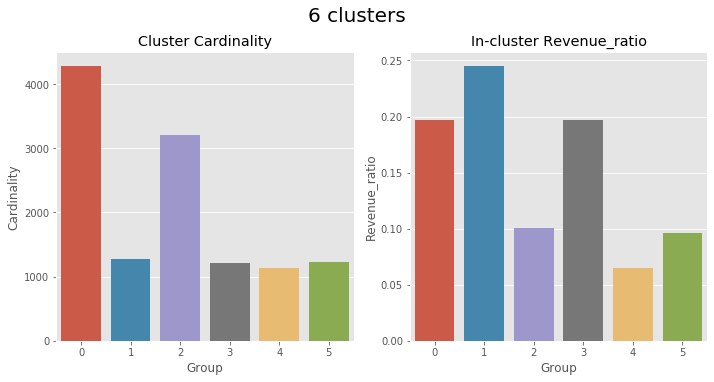

In [91]:
plot = grouped_revenue(data, AgglomerativeClustering(n_clusters=6, linkage='ward'))
plot.suptitle('6 clusters', fontsize=20, y=1.05);

Jak widać, uzyskaliśmy podział na 6 grup, każda o liczności co najmniej 1000 sesji. Mamy tutaj 3 grupy o Revenue_ratio <= 0.10 i 3 grupy o Revenue_ratio >= 0.20, a zatem conajmniej dwukrotnie większym.

Ostatnim razem, by znaleźć czynniki najbardziej decydujące o przynależności obserwacji do danej grupy, wytrenowaliśmy model klasyfikacji XGBoost do przewidywania zmiennej 'Revenue' i porównaliśmy wykres Feature Importance uzyskanego modelu ze statystykami pozycyjnymi poszczególnych grup.

Tym razem, stworzymy 6 modeli, każdy służyć będzie do przewidywania przynależności obserwacji do jednej z 6 grup (One vs. All).

Dzięki temu, uzyskamy 6 wykresów Feature Importance, opisujących charakterystykę każdej z grup w sposób indywidualny.

Ponadto, uzyskane modele pozwolą nam na stworzenie funkcji, przypisującej etykiety grup pojedyńczym, nowym obserwacjom - coś, na co Agglomerative Clustering nam nie pozwala.

## Modelowanie

Najpierw przygotujemy dane z etykietami grup.

In [92]:
model = AgglomerativeClustering(n_clusters=6, linkage='ward')
prediction = pd.Series(_predict(data.drop('Revenue', axis=1), model))
prediction.name = 'Group'
data = pd.concat([data, prediction], axis=1)
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_x,Month_y,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_other,Browser_1,Browser_2,Browser_4,Browser_5,Browser_other,Region_1,Region_2,Region_3,Region_4,Region_other,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_other,Group
0,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5
1,0.000000,0.000000,0.0,0.0,0.002837,0.001000,0.000000,0.500000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
2,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3
3,0.000000,0.000000,0.0,0.0,0.002837,0.000042,0.250000,0.700000,0.000000,0.0,0,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,0.000000,0.000000,0.0,0.0,0.014184,0.009809,0.100000,0.250000,0.000000,0.0,1,0,8.660254e-01,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,1,0,-2.449294e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,1,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,0,0,-5.000000e-01,0.866025,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


Teraz zdefiniujemy funkcję, która wytrenuje model do przewidywania przynależności do zadanej grupy. Uwzględnimy strojenie hiperparametrów.

In [93]:
def group_classification(data, group, estimator, param_distributions, scoring, n_iter, cv, n_jobs=-1, verbose=True):
    data = data.drop('Revenue', axis=1)
    data.loc[:, 'Group']=(data.loc[:, 'Group']==group).astype(int)
    random=RandomizedSearchCV(estimator=estimator, param_distributions=params, scoring=scoring, n_iter=n_iter, cv=cv, n_jobs=n_jobs, verbose=verbose)
    random_result=random.fit(data.drop('Group', axis=1), data.Group)
    return random_result.best_score_, random_result.best_estimator_ 

Stworzymy jeszcze siatkę parametrów.

In [94]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# domyslnie 'gbtree'
# "...I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used."
booster=['gbtree']

# domyslnie 0.3
# musi byc z zakresu [0, 1]
# "Typical final values to be used are 0.01-0.2."
learning_rate=uniform(loc=0.01, scale=0.49)

# domyslnie 1
# musi byc z zakresu [1, ∞]
min_child_weight=randint(low=1, high=10)

# domyslnie 6
# musi byc z zakresu [1, ∞]
# "Beware that XGBoost aggressively consumes memory when training a deep tree."
max_depth=randint(low=1, high=10)

# domyslnie 0
# https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6
# "Gamma values around 20 are extremely high."
# scale=1/lambda
min_split_loss=uniform(loc=0, scale=20)
# lub
# min_split_loss=expon(scale=1/0.2)
# mozna podejrzec, P(X<20)~=0.98168
# r=min_split_loss.rvs(size=1000)
# sorted(r)

# domyslnie 0
# "Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced."
# "This is generally not used but you can explore further if you wish."
# "Set it to value of 1-10 might help control the update."
max_delta_step=uniform(loc=0, scale=10)

# domyslnie 1
# musi byc z zakresu (0, 1]
# "Typical values are 0.5-1."
subsample=uniform(loc=0.1, scale=0.9)

# domyslnie 1
# musi byc z zakresu (0, 1]
# "Typical values are 0.5-1"
colsample_bytree=uniform(loc=0.1, scale=0.9)

# domyslnie 1
# "I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so."
colsample_bylevel=[1]

# domyslnie 1
# "This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting."
reg_lambda=uniform(loc=0, scale=3)

# domyslnie 0
# "Can be used in case of very high dimensionality so that the algorithm runs faster when implemented."
reg_alpha=uniform(loc=0, scale=3)

# domyslnie 1
# "A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence."
scale_pos_weight=uniform(loc=0, scale=3)

# domyslnie 100
n_estimators=randint(50, 150)

params={
        'xgbclassifier__booster': booster, 
        'xgbclassifier__learning_rate': learning_rate,
        'xgbclassifier__min_child_weight': min_child_weight, 
        'xgbclassifier__max_depth': max_depth,
        'xgbclassifier__min_split_loss': min_split_loss, 
        'xgbclassifier__max_delta_step': max_delta_step, 
        'xgbclassifier__subsample': subsample, 
        'xgbclassifier__colsample_bytree': colsample_bytree, 
        'xgbclassifier__colsample_bylevel': colsample_bylevel, 
        'xgbclassifier__reg_lambda': reg_lambda, 
        'xgbclassifier__reg_alpha': reg_alpha, 
        'xgbclassifier__scale_pos_weight': scale_pos_weight,
        'xgbclassifier__n_estimators': n_estimators
}

Teraz wyszkolimy model dla każdej z 6 grup. Z racji na niezbalansowanie, jako miary użyjemy BACC.

In [104]:
scores=[]
models=[]

for i in range(6):
    print('model %s'%i)
    xgb=XGBClassifier(n_jobs=-1)
    score, model=group_classification(data=data, group=i, estimator=xgb, param_distributions=params, scoring='balanced_accuracy', n_iter=100, cv=3)
    scores.append(score)
    models.append(model)
 
# mozna tez wczytać
# models = load('models.joblib')  
# scores = load('scores.joblib')

model 0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


model 1
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


model 2
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


model 3
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


model 4
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


model 5
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


Uzyskane modele i ich wyniki warto zapisać do plików.

In [117]:
dump(models, 'models.joblib'); 
dump(scores, 'scores.joblib');

Sprawdźmy, jakie są wyniki naszych modeli.

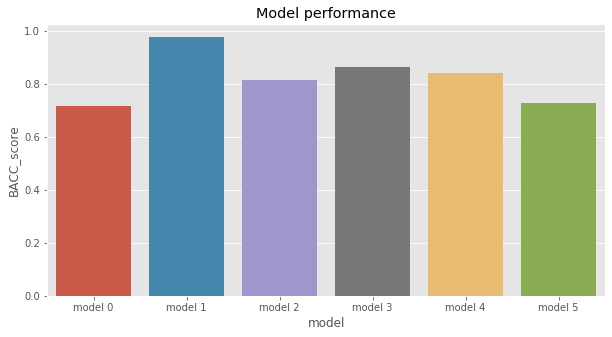

In [116]:
temp = ['model %s'%i for i in range(6)]
plot_data = pd.DataFrame({'model': temp, 'BACC_score': scores})
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x='model', y='BACC_score', data=plot_data).set_title('Model performance');

Wyniki są całkiem dobre.

Możemy teraz spojrzeć indywidualnie na Feature Importance dla każdej z 6 grup.

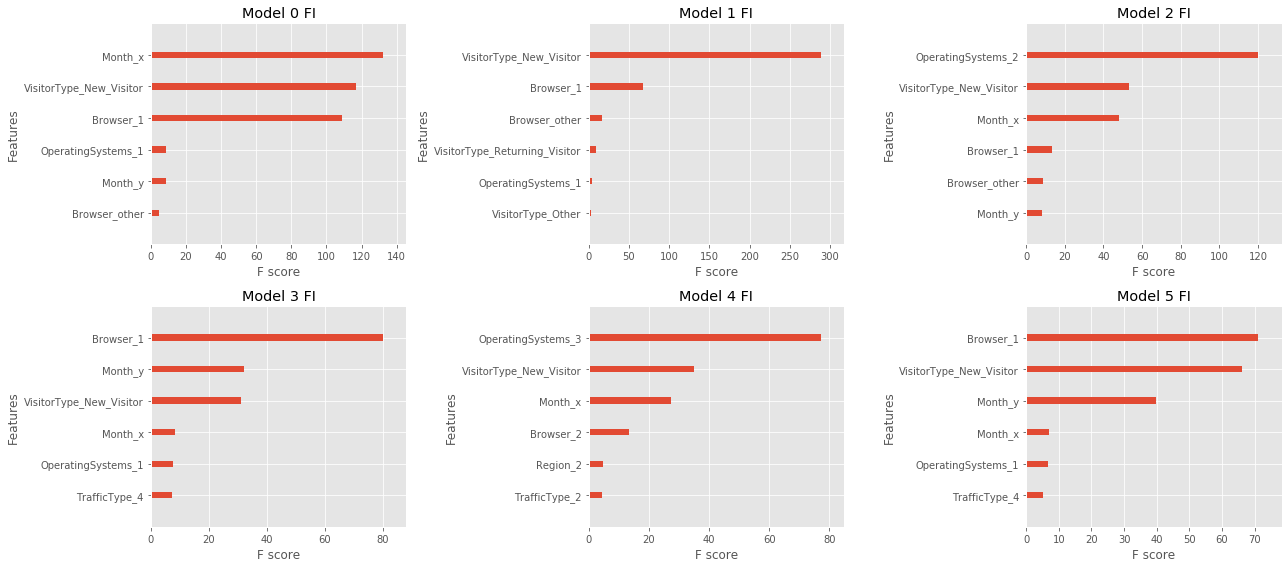

In [183]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8)) 
for i in range(6):
    with plt.style.context('ggplot'):
        plot_importance(models[i], ax=ax[i//3, i%3], importance_type='gain', show_values=False, max_num_features=6, title='Model %s FI'%i);
plt.tight_layout();